In [64]:
import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt

# 03 Posture Detection

This notebook contains a simple **frame detection setup** using **MediaPipe's posture detection** module.  
Most of the code used here is based on **Google’s official example**, and the **landmark model** is a **fully trained model developed by Google**.  

The main purpose of this notebook is to **test the model** and **analyze my posture** during **front squats** and **deadlifts**, as I’ve always been curious about how accurate my form actually is.

The notebook is just a frame wise detection, while the whole video processing is executed in the **detector.py**

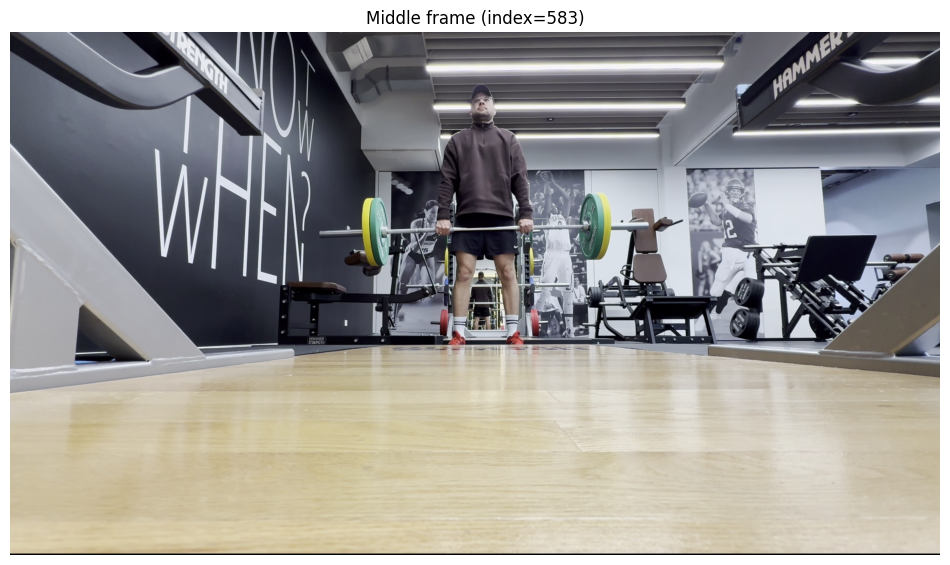

In [65]:
# Open the video file
video_path = '/root/projects/03_posture_detection/original-videos/deadlift-front-0.MOV'
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file")
    exit()

# Get total number of frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
middle_index = total_frames // 2

# Set the frame position to the middle frame
cap.set(cv2.CAP_PROP_POS_FRAMES, middle_index)
ret, middle_frame = cap.read()
cv2.imwrite("middle_frame.jpg", middle_frame)

if not ret:
    print("Error: Could not read middle frame")

# Release the video capture object
cap.release()

# Convert BGR (OpenCV) to RGB for matplotlib
rgb_middle = cv2.cvtColor(middle_frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 7))
plt.imshow(rgb_middle)
plt.axis('off')
plt.title(f"Middle frame (index={middle_index})")
plt.show()

In [77]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
    if pose_landmarks[23]:
      

      x1 = pose_landmarks[23].x
      y1 = pose_landmarks[23].y
      x2 = pose_landmarks[24].x
      y2 = pose_landmarks[24].y

      x_dist = abs(x1 - x2)
      y_dist = abs(y1 - y2)

      rad = np.atan(y_dist/x_dist)
      degree = int(np.rad2deg(rad))


      # font
      font = cv2.FONT_HERSHEY_SIMPLEX

      # org
      org = (50, 50)

      # fontScale
      fontScale = 1
      
      # Blue color in BGR
      def angle_to_color(angle_deg):
          """
          Maps an angle from 0 to 90 degrees to a color from light blue → light red.
          Output format: (B, G, R)
          """

          # Clamp angle into 0–90
          a = np.clip(angle_deg, 0, 90) / 90.0  # normalized to 0..1

          # Define start and end colors (B, G, R)
          light_blue = np.array([255, 200, 100], dtype=np.float32)
          light_red  = np.array([100, 150, 255], dtype=np.float32)

          # Linear interpolation
          color = (1 - a) * light_blue + a * light_red

          # Return as tuple (0,0,0)
          return (int(color[0]), int(color[1]), int(color[2]))
      
      color = angle_to_color(degree)
      print(color)

      # Line thickness of 2 px
      thickness = 2
      annotated_image = cv2.putText(annotated_image, f'hip angle: {degree} degree', org, fontFace=font, fontScale=fontScale, color=color, thickness=thickness)
    
  return annotated_image

I0000 00:00:1763459918.463126  125542 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763459918.472322  133388 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.0.7-0ubuntu0.24.04.1), renderer: llvmpipe (LLVM 19.1.1, 256 bits)
W0000 00:00:1763459918.852020  133390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763459918.872267  133402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


(244, 196, 110)


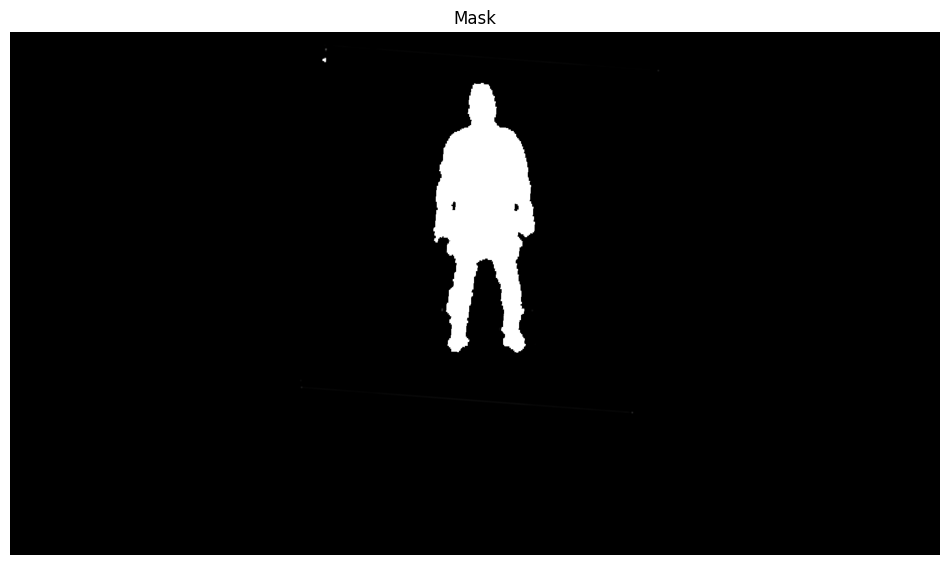

In [78]:


# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='/root/models/pose_landmarker_full.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("middle_frame.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2.imwrite("annotated_image.jpg",cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))



segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
cv2.imwrite("mask.jpg", visualized_mask)

rgb_mask = cv2.cvtColor(visualized_mask, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 7))
plt.imshow(rgb_mask)
plt.axis('off')
plt.title("Mask")
plt.show()



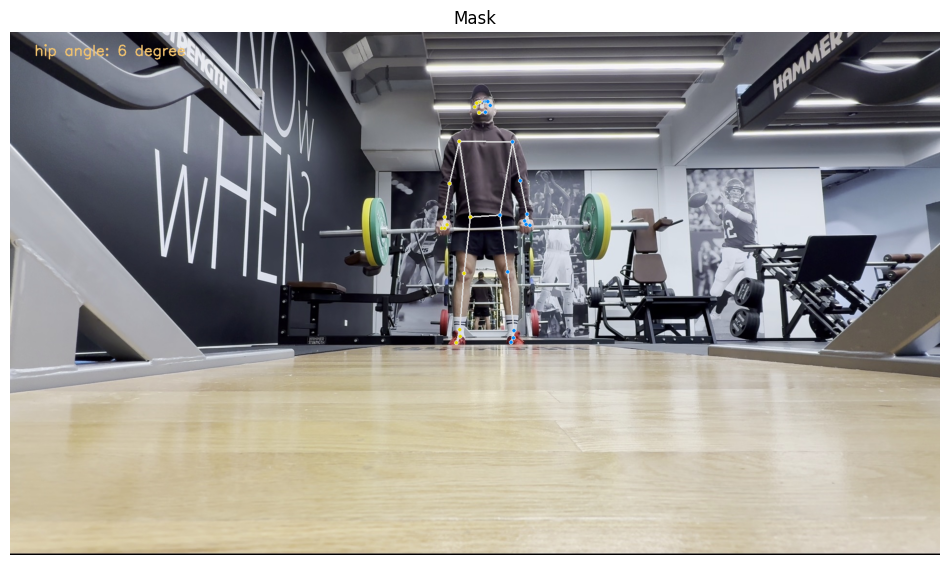

In [79]:
plt.figure(figsize=(12, 7))
plt.imshow(annotated_image)
plt.axis('off')
plt.title("Mask")
plt.show()